In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [2]:
url = '/content/drive/MyDrive/Soft Computing/'

In [7]:
dataset_C = url + 'Dataset C.zip'
with ZipFile(dataset_C, 'r') as zip:
  zip.extractall()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
PATH = '/content/'
data_labels = pd.read_csv(PATH + 'training-c.csv', usecols = ['filename', 'digit'])
print(data_labels.shape)
data_labels.head()

(24298, 2)


,filename,digit
0,c00000.png,6
1,c00001.png,1
2,c00002.png,3
3,c00003.png,2
4,c00004.png,7


In [11]:
TRAIN_PATH = url + 'Train'
os.mkdir(TRAIN_PATH)

def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('training-c')

In [12]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [13]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(data_labels, TRAIN_PATH, train_transform)
test_data = Dataset(data_labels, TRAIN_PATH, test_transform)

print("Trainig Samples: ", len(train_data))

Trainig Samples:  24298


# **Base Parameters**

In [42]:
batch_size = 85
num_iters = 10000
input_dim = 28*28
num_hidden = 250
output_dim = 10

learning_rate = 0.01

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

34


In [15]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:972
Test dataloader:243


In [16]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [21]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [43]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Iteration: 500. Loss: 0.795386791229248. Accuracy: 76.5178020168759
Epoch:  2
Iteration: 1000. Loss: 0.6545535326004028. Accuracy: 77.83494546202922
Iteration: 1500. Loss: 0.6815522909164429. Accuracy: 76.64128421485903
Epoch:  3
Iteration: 2000. Loss: 0.607199490070343. Accuracy: 76.92940934348631
Iteration: 2500. Loss: 0.8921245336532593. Accuracy: 75.40646223502779
Epoch:  4
Iteration: 3000. Loss: 0.7679108381271362. Accuracy: 75.50936406668039
Iteration: 3500. Loss: 0.427132785320282. Accuracy: 76.55896274953695
Epoch:  5
Iteration: 4000. Loss: 0.6243266463279724. Accuracy: 77.48507923441038
Iteration: 4500. Loss: 0.7116197347640991. Accuracy: 70.79646017699115
Epoch:  6
Iteration: 5000. Loss: 0.3251429796218872. Accuracy: 79.0080263428689
Iteration: 5500. Loss: 0.39745691418647766. Accuracy: 79.35789257048775
Epoch:  7
Iteration: 6000. Loss: 0.9500070810317993. Accuracy: 74.56266721547644
Iteration: 6500. Loss: 0.5364434123039246. Accuracy: 73.98641695822185
Epoch:  8
It

In [44]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Soft Computing/model_base.pkl')

[0.795386791229248, 0.6545535326004028, 0.6815522909164429, 0.607199490070343, 0.8921245336532593, 0.7679108381271362, 0.427132785320282, 0.6243266463279724, 0.7116197347640991, 0.3251429796218872, 0.39745691418647766, 0.9500070810317993, 0.5364434123039246, 0.6384643316268921, 1.00753915309906, 1.1048933267593384, 0.4735003113746643, 0.4080143868923187, 0.6140328645706177, 0.4718947410583496, 0.3906680643558502, 0.23422019183635712, 0.7965720295906067, 0.52215975522995, 0.31841033697128296, 0.4041542112827301, 0.6637927293777466, 0.6610797643661499, 0.2537044882774353, 0.4842740595340729, 0.32587167620658875, 0.7453140020370483, 0.272183358669281, 0.7240437269210815, 0.3163500428199768, 0.6800118684768677, 0.5994155406951904, 0.8102424740791321, 0.22597047686576843, 0.3603719174861908, 0.2640533745288849, 0.6745779514312744, 0.498358815908432, 0.4622839093208313, 0.337338387966156, 0.27554503083229065, 0.4585346579551697, 0.35004156827926636, 0.552043080329895, 0.5596837401390076, 0.2

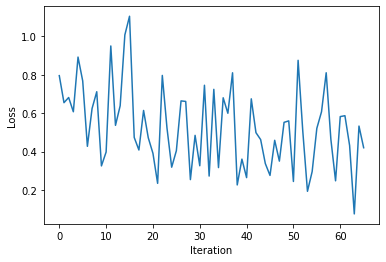

In [45]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()